# SAE Sparse Activations vs Alanine Position Correlation Analysis

This notebook investigates whether the sparse monosemantic features learned by our SAEs correlate with known biological features. We do this here by analyzing correlations between activations of the hidden activations from a pre-trained SAE model and alanine (an amino acid) positions in nucleotide sequences. 

## Overview
- Load pre-trained SAE pipeline
- Process RefSeq GenBank data
- Extract alanine positions (EGCU, EGCC, EGCA, EGCG patterns)
- Generate sparse activations
- Calculate Pearson correlations
- Perform statistical analysis
- Create visualizations

## Setup and Imports

In [1]:
import sys
from pathlib import Path
import json
import time
from typing import Dict, List, Tuple, Optional, Any
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr
from statsmodels.stats.multitest import multipletests
from tqdm import tqdm
import torch
import multiprocessing

# Try to import joblib for parallel processing
try:
    from joblib import Parallel, delayed
    JOBLIB_AVAILABLE = True
except ImportError:
    JOBLIB_AVAILABLE = False
    print("⚠️  Joblib not available. Install with: pip install joblib")

# Add the src directory to the path
script_dir = Path.cwd()
src_path = script_dir.parent / "src"
sys.path.append(str(src_path))

from sae.pipeline import SAETrainingPipeline
from sae.preprocessing.refseq_preprocessor import RefSeqPreprocessor
from sae.metrics.correlation_analysis import cuda_calculate_correlation_matrix

print("✅ All imports successful")

INFO:datasets:PyTorch version 2.6.0 available.


✅ All imports successful


## Configuration

In [4]:
# Configuration
model_path = "../outputs/ablation_study_reconstruction/regular_sae_latent_1000"
refseq_file = "../../data/vertebrate_mammalian.1.rna.gbff"
output_dir = "../outputs/correlation_analysis"
max_samples = 50  # Start with smaller sample for testing
batch_size = 1
max_length = 1024

# Create output directory
output_path = Path(output_dir)
output_path.mkdir(parents=True, exist_ok=True)

print(f"🔬 Correlation Analysis Configuration")
print(f"   Model path: {model_path}")
print(f"   RefSeq file: {refseq_file}")
print(f"   Max samples: {max_samples}")
print(f"   Max length: {max_length}")
print(f"   Batch size: {batch_size}")
print(f"   Output directory: {output_dir}")

🔬 Correlation Analysis Configuration
   Model path: ../outputs/ablation_study_reconstruction/regular_sae_latent_1000
   RefSeq file: ../../data/vertebrate_mammalian.1.rna.gbff
   Max samples: 50
   Max length: 1024
   Batch size: 1
   Output directory: ../outputs/correlation_analysis


## Step 1: Load Pre-trained Pipeline

In [5]:
print("📥 Loading pre-trained SAE pipeline...")

# Load the pipeline from the saved directory
pipeline = SAETrainingPipeline.load_from_checkpoint(model_path)

# Update embedding generator configuration for memory efficiency
if hasattr(pipeline, 'embedding_generator'):
    # Update the embedding generator's configuration
    pipeline.embedding_generator.batch_size = batch_size
    pipeline.embedding_generator.max_length = max_length
    print(f"   🔧 Updated embedding batch size to: {batch_size}")
    print(f"   🔧 Updated embedding max_length to: {max_length}")
    
    # Re-load the model with new configuration
    pipeline.embedding_generator._load_model()
    print(f"   ✅ Re-loaded embedding generator with new config")

print(f"   ✅ Pipeline loaded successfully")
print(f"   Model: {pipeline.sae_model.__class__.__name__}")
print(f"   Device: {pipeline.device}")
print(f"   Batch size: {batch_size}")
print(f"   Max length: {max_length}")

INFO:sae.pipeline.base_pipeline:✅ SAE model setup complete: 256 -> 1000
INFO:sae.pipeline.embedding_generator:Loading HelicalmRNA model with wrapper: helicalmRNA
INFO:sae.pipeline.embedding_generator:✅ Model and preprocessor loaded successfully
INFO:sae.pipeline.base_pipeline:✅ Embedding generator setup complete
INFO:sae.pipeline.embedding_generator:Loading HelicalmRNA model with wrapper: helicalmRNA
INFO:sae.pipeline.embedding_generator:✅ Model and preprocessor loaded successfully


📥 Loading pre-trained SAE pipeline...
   🔧 Updated embedding batch size to: 1
   🔧 Updated embedding max_length to: 1024
   ✅ Re-loaded embedding generator with new config
   ✅ Pipeline loaded successfully
   Model: SAE
   Device: cuda
   Batch size: 1
   Max length: 1024


## Step 2: Process RefSeq Data

Same as before.

In [6]:
print("📊 Processing RefSeq data...")

# Initialize preprocessor
preprocessor = RefSeqPreprocessor()

# Process RefSeq data
processed_records = preprocessor.process_refseq_file(
    file_path=refseq_file,
    max_samples=max_samples,
    use_cds=True,
    max_length=max_length
)

print(f"   ✅ Processed {len(processed_records)} records")

# Print feature summary
feature_stats = preprocessor.get_processing_statistics(processed_records)
print("   📋 Feature Summary:")
for feature_type, count in feature_stats.get('feature_counts', {}).items():
    print(f"     {feature_type}: {count}")

# Print alanine statistics
total_alanine = sum(record['feature_statistics'].get('alanine_count', 0) for record in processed_records)
records_with_alanine = sum(1 for record in processed_records if record['feature_statistics'].get('has_alanine', False))
print(f"   🧬 Alanine Statistics:")
print(f"     Total alanine positions: {total_alanine}")
print(f"     Records with alanine: {records_with_alanine}")

INFO:sae.preprocessing.refseq_preprocessor:Processing RefSeq file: ../../data/vertebrate_mammalian.1.rna.gbff
INFO:sae.preprocessing.refseq_preprocessor:Found approximately 100 records to process
INFO:sae.preprocessing.refseq_preprocessor:Filtering sequences to max length: 1024


📊 Processing RefSeq data...


Processing records: 340record [00:00, 702.53record/s]                    
INFO:sae.preprocessing.refseq_preprocessor:✅ Processing complete:
INFO:sae.preprocessing.refseq_preprocessor:   Total processed: 341
INFO:sae.preprocessing.refseq_preprocessor:   Valid sequences: 50
INFO:sae.preprocessing.refseq_preprocessor:   Rejected (too long): 291
INFO:sae.preprocessing.refseq_preprocessor:   Final valid records: 50


   ✅ Processed 50 records
   📋 Feature Summary:
   🧬 Alanine Statistics:
     Total alanine positions: 575
     Records with alanine: 50


## Step 3: Generate Activations and Alanine Masks

Our preprocessor looks all subsequences in our preprocessed data of "EGCU", EGCC", "EGCA", or "EGCG", corresponding to the four codons which code for alanine. This in translated into a boolean mask in the processed records which we can use for our correlation computation.

In [7]:
print("🧠 Generating sparse activations...")

# Clear GPU cache before generating embeddings
if torch.cuda.is_available():
    torch.cuda.empty_cache()
    print("   🧹 Cleared CUDA cache")

# Extract sequences
sequences = [record['final_sequence'] for record in processed_records]

# Use pipeline to generate embeddings and activations
embeddings = pipeline.embedding_generator.wrapper(sequences)

# Convert to numpy if it's a tensor
if isinstance(embeddings, torch.Tensor):
    embeddings = embeddings.cpu().numpy()

# Use forward method and extract latent activations (encoded)
with torch.no_grad():
    # Pass embeddings directly to SAE model (preserving sequence length)
    reconstructed, activations = pipeline.sae_model.forward(torch.tensor(embeddings, device=pipeline.device))
    activations = activations.cpu().numpy()

# Extract alanine masks from preprocessor
alanine_masks = []
alanine_count = 0
for i, record in enumerate(processed_records):
    masks = record['feature_masks']
    alanine_masks.append(masks['alanine'])
    alanine_count += masks['alanine'].sum()
    
    # Debug: Check first few sequences
    if i < 2:
        sequence = record['final_sequence']
        alanine_mask = masks['alanine']
        print(f"   🔍 Record {i}: sequence length={len(sequence)}")
        print(f"   🔍 Record {i}: sequence[:50]={sequence[:50]}")
        print(f"   🔍 Record {i}: alanine mask sum={alanine_mask.sum()}")
        # Find alanine patterns in sequence
        alanine_patterns = []
        for j in range(len(sequence) - 3):
            if sequence[j:j+4] in ["EGCU", "EGCC", "EGCA", "EGCG"]:
                alanine_patterns.append((j, sequence[j:j+4]))
        print(f"   🔍 Record {i}: found {len(alanine_patterns)} alanine patterns: {alanine_patterns[:5]}")
        print(f"   🔍 Record {i}: mask alanine positions: {np.where(alanine_mask)[0][:10]}")
        print()

print(f"   ✅ Generated activations: {activations.shape}")
print(f"   ✅ Collected {len(alanine_masks)} alanine masks")
print(f"   ✅ Found {alanine_count} total alanine positions")

# Debug: Check alanine distribution
alanine_per_sequence = [mask.sum() for mask in alanine_masks]
print(f"   🔍 Alanine per sequence: min={min(alanine_per_sequence)}, max={max(alanine_per_sequence)}, mean={np.mean(alanine_per_sequence):.2f}")
print(f"   🔍 Sequences with alanine: {sum(1 for count in alanine_per_sequence if count > 0)}/{len(alanine_per_sequence)}")

🧠 Generating sparse activations...
   🧹 Cleared CUDA cache


INFO:helical.models.helix_mrna.model:Helix-mRNA initialized successfully.
INFO:helical.models.helix_mrna.model:'helical-ai/Helix-mRNA' model is in 'eval' mode, on device 'cuda'.
INFO:sae.preprocessing.helical_wrapper:Helical model loaded successfully on cuda
INFO:helical.models.helix_mrna.model:Processing data for Helix-mRNA.
INFO:helical.models.helix_mrna.model:Successfully processed the data for Helix-mRNA.
INFO:sae.preprocessing.helical_wrapper:Processed 50 sequences with Helical model
INFO:helical.models.helix_mrna.model:Started getting embeddings:
Getting embeddings: 100%|██████████| 50/50 [00:07<00:00,  6.43it/s]
INFO:helical.models.helix_mrna.model:Finished getting embeddings.
INFO:sae.preprocessing.helical_wrapper:Generated embeddings with shape: (50, 989, 256)


   🔍 Record 0: sequence length=160
   🔍 Record 0: sequence[:50]=EGUCEUACEGGCECAUEACCEACCECUGEAACEGCGECCCEGAUECUCEG
   🔍 Record 0: alanine mask sum=4
   🔍 Record 0: found 1 alanine patterns: [(32, 'EGCG')]
   🔍 Record 0: mask alanine positions: [32 33 34 35]

   🔍 Record 1: sequence length=160
   🔍 Record 1: sequence[:50]=EGUCEUACEGGCECAUEACCEACCECUGEAACEGCGECCCEGAUECUCEG
   🔍 Record 1: alanine mask sum=4
   🔍 Record 1: found 1 alanine patterns: [(32, 'EGCG')]
   🔍 Record 1: mask alanine positions: [32 33 34 35]

   ✅ Generated activations: (50, 989, 1000)
   ✅ Collected 50 alanine masks
   ✅ Found 2300 total alanine positions
   🔍 Alanine per sequence: min=4, max=140, mean=46.00
   🔍 Sequences with alanine: 50/50


## Step 4: Calculate Correlations

We build a custom function for GPUs for fast computation of the correlation of all 1000 features with our alanine mask.

In [8]:
print("📈 Calculating alanine position correlations...")

# Handle both 2D and 3D activations
if len(activations.shape) == 3:
    # 3D activations: (n_sequences, seq_len, n_latents)
    n_sequences, seq_len, n_latents = activations.shape
    # Reshape to (n_sequences * seq_len, n_latents) for processing
    activations_2d = activations.reshape(-1, n_latents)
else:
    # 2D activations: (n_sequences, n_latents)
    n_sequences, n_latents = activations.shape
    activations_2d = activations
    seq_len = 1

# Pre-process alanine masks into a single array for vectorized operations
print("   🔄 Preprocessing alanine masks...")

# Use the actual sequence length from activations, not from masks
if len(activations.shape) == 3:
    # 3D activations: (n_sequences, seq_len, n_latents)
    actual_seq_len = activations.shape[1]
else:
    # 2D activations: (n_sequences, n_latents) - no sequence dimension
    actual_seq_len = 1

print(f"   🔍 Activations shape: {activations.shape}")
print(f"   🔍 Using sequence length: {actual_seq_len}")

# Add feature dimension to make it compatible with CUDA function: (n_sequences, 1, actual_seq_len)
feature_array = np.zeros((n_sequences, 1, actual_seq_len))

for seq_idx, mask in enumerate(alanine_masks):
    seq_len = min(mask.shape[0], actual_seq_len)  # Don't exceed actual sequence length
    feature_array[seq_idx, 0, :seq_len] = mask[:seq_len].astype(float)
    
    # Debug: Check first few sequences
    if seq_idx < 3:
        print(f"   🔍 Seq {seq_idx}: mask shape={mask.shape}, seq_len={seq_len}, alanine_count={mask.sum()}")
        print(f"   🔍 Seq {seq_idx}: alanine positions={np.where(mask)[0][:10]}")  # First 10 alanine positions

print(f"   🔍 Feature array shape: {feature_array.shape}")
print(f"   🔍 Total alanine positions in feature array: {feature_array.sum()}")
print(f"   🔍 Non-zero entries: {np.count_nonzero(feature_array)}")

📈 Calculating alanine position correlations...
   🔄 Preprocessing alanine masks...
   🔍 Activations shape: (50, 989, 1000)
   🔍 Using sequence length: 989
   🔍 Seq 0: mask shape=(160,), seq_len=160, alanine_count=4
   🔍 Seq 0: alanine positions=[32 33 34 35]
   🔍 Seq 1: mask shape=(160,), seq_len=160, alanine_count=4
   🔍 Seq 1: alanine positions=[32 33 34 35]
   🔍 Seq 2: mask shape=(160,), seq_len=160, alanine_count=4
   🔍 Seq 2: alanine positions=[32 33 34 35]
   🔍 Feature array shape: (50, 1, 989)
   🔍 Total alanine positions in feature array: 2300.0
   🔍 Non-zero entries: 2300


In [9]:
# Try CUDA tensor operations first (fastest)
correlations = {}
p_values = {}

try:
    if torch.cuda.is_available():
        print("   🚀 Using CUDA tensor operations...")
        pearson_corr, pearson_p = cuda_calculate_correlation_matrix(
            activations_2d, feature_array
        )
        
        # Convert results to dictionary format
        for latent_idx in range(n_latents):
            if pearson_corr[latent_idx, 0] != 0:  # Only include valid correlations
                correlations[(latent_idx, 'alanine')] = {
                    'pearson': float(pearson_corr[latent_idx, 0]),
                    'pearson_p': float(pearson_p[latent_idx, 0])
                }
                p_values[(latent_idx, 'alanine')] = float(pearson_p[latent_idx, 0])
        
        print(f"   ✅ CUDA calculation completed")
        
    else:
        raise Exception("CUDA not available")
        
except Exception as e:
    print(f"   ⚠️  CUDA calculation failed: {e}")
    print("   🔄 Falling back to parallel processing...")
    
    # Fall back to parallel processing method
    print("   🔄 Using parallel processing fallback...")
    # Create all combinations of latent-alanine pairs for parallel processing
    latent_feature_pairs = []
    for latent_idx in range(n_latents):
        latent_feature_pairs.append((latent_idx, 0, 'alanine'))
    
    print(f"   🔄 Processing {len(latent_feature_pairs)} latent-alanine pairs...")
    
    # For fallback processing, we need to extract the 2D alanine array
    alanine_array_2d = feature_array[:, 0, :]  # Shape: (n_sequences, max_seq_len)
    
    def calculate_single_correlation(latent_idx, feature_idx, feature_type, activations, feature_array):
        """Calculate correlation for a single latent-alanine pair."""
        try:
            # Get latent activations for this dimension
            latent_activations = activations[:, latent_idx]  # Shape: (n_sequences,)
            
            # Get alanine values (feature_array is now 2D: n_sequences, seq_len)
            feature_values = feature_array  # Shape: (n_sequences, max_seq_len)
            
            # Create data points: for each sequence, repeat the activation value for each token
            activation_values = np.repeat(latent_activations, feature_values.shape[1])
            feature_values_flat = feature_values.flatten()
            
            # For binary features, we need to include both 0s and 1s
            valid_mask = np.ones_like(feature_values_flat, dtype=bool)
            
            activation_values = activation_values[valid_mask]
            feature_values_flat = feature_values_flat[valid_mask]
            
            if latent_idx == 0:  # Debug only for first latent
                print(f"   🔍 Latent {latent_idx}: {valid_mask.sum()} valid data points, alanine values: {feature_values_flat.sum()}")
            
            # Calculate correlations
            corr, p_val = pearsonr(activation_values, feature_values_flat)
            
            corr_data = {
                'pearson': corr,
                'pearson_p': p_val
            }
            
            return (latent_idx, feature_type, corr_data, p_val)
            
        except Exception as e:
            print(f"   ⚠️  Error calculating correlation for latent {latent_idx}, feature {feature_type}: {e}")
            return None
    
    # Use parallel processing for correlation calculations
    if JOBLIB_AVAILABLE:
        try:
            n_jobs = min(multiprocessing.cpu_count(), len(latent_feature_pairs))
            print(f"   🔄 Using {n_jobs} parallel workers...")
            
            results = Parallel(n_jobs=n_jobs, verbose=1)(
                delayed(calculate_single_correlation)(
                    latent_idx, feature_idx, feature_type, activations_2d, alanine_array_2d
                )
                for latent_idx, feature_idx, feature_type in latent_feature_pairs
            )
            
        except Exception as e:
            print(f"   ⚠️  Parallel processing failed: {e}")
            print("   🔄 Using sequential processing...")
            results = []
            for latent_idx, feature_idx, feature_type in tqdm(latent_feature_pairs, desc="Calculating correlations"):
                result = calculate_single_correlation(
                    latent_idx, feature_idx, feature_type, activations_2d, alanine_array_2d
                )
                results.append(result)
    else:
        print("   ⚠️  joblib not available, using sequential processing...")
        results = []
        for latent_idx, feature_idx, feature_type in tqdm(latent_feature_pairs, desc="Calculating correlations"):
            result = calculate_single_correlation(
                latent_idx, feature_idx, feature_type, activations_2d, alanine_array_2d
            )
            results.append(result)
    
    # Process results
    for result in results:
        if result is not None:
            latent_idx, feature_type, corr_data, p_val = result
            correlations[(latent_idx, feature_type)] = corr_data
            p_values[(latent_idx, feature_type)] = p_val

print(f"   ✅ Calculated correlations for {len(correlations)} latent-alanine pairs")

   🚀 Using CUDA tensor operations...
   🔄 Using CUDA tensor operations on cuda
   📊 Processing 1000 latents × 1 features = 1000 correlations
   📊 Activations shape: (49450, 1000), Features shape: (50, 1, 989)
   📊 Flattened features shape: torch.Size([49450, 1])
   🔄 Using batched processing: 50 latents × 5 features per batch
   🔄 Processing batch: latents 0-49, features 0-0
   🔄 Processing batch: latents 50-99, features 0-0
   🔄 Processing batch: latents 100-149, features 0-0
   🔄 Processing batch: latents 150-199, features 0-0
   🔄 Processing batch: latents 200-249, features 0-0
   🔄 Processing batch: latents 250-299, features 0-0
   🔄 Processing batch: latents 300-349, features 0-0
   🔄 Processing batch: latents 350-399, features 0-0
   🔄 Processing batch: latents 400-449, features 0-0
   🔄 Processing batch: latents 450-499, features 0-0
   🔄 Processing batch: latents 500-549, features 0-0
   🔄 Processing batch: latents 550-599, features 0-0
   🔄 Processing batch: latents 600-649, f

## Step 5: Statistical Analysis

In [10]:
print("📊 Performing statistical analysis...")

pval_list = list(p_values.values())
keys = list(p_values.keys())

if len(pval_list) == 0:
    print("   ⚠️  No p-values to analyze")
    statistical_results = {}
else:
    try:
        _, corrected_pvals, _, _ = multipletests(pval_list, method='fdr_bh', alpha=0.05)
        corrected_dict = dict(zip(keys, corrected_pvals))
        
        significant = {key: p_val for key, p_val in corrected_dict.items() if p_val < 0.05}
        
        print(f"   ✅ Corrected {len(pval_list)} p-values")
        print(f"   ✅ Found {len(significant)} significant correlations")
        
        statistical_results = {
            'corrected_p_values': corrected_dict,
            'significant_features': significant,
            'total_tests': len(pval_list)
        }
        
    except Exception as e:
        print(f"   ❌ Error in statistical analysis: {e}")
        statistical_results = {}

📊 Performing statistical analysis...
   ✅ Corrected 1000 p-values
   ✅ Found 0 significant correlations


## Step 6: Create Visualizations

Let's visualize some results of our analysis!

📊 Creating alanine position visualizations...
   📈 Plot saved to: ../outputs/correlation_analysis/alanine_position_correlation_analysis.png


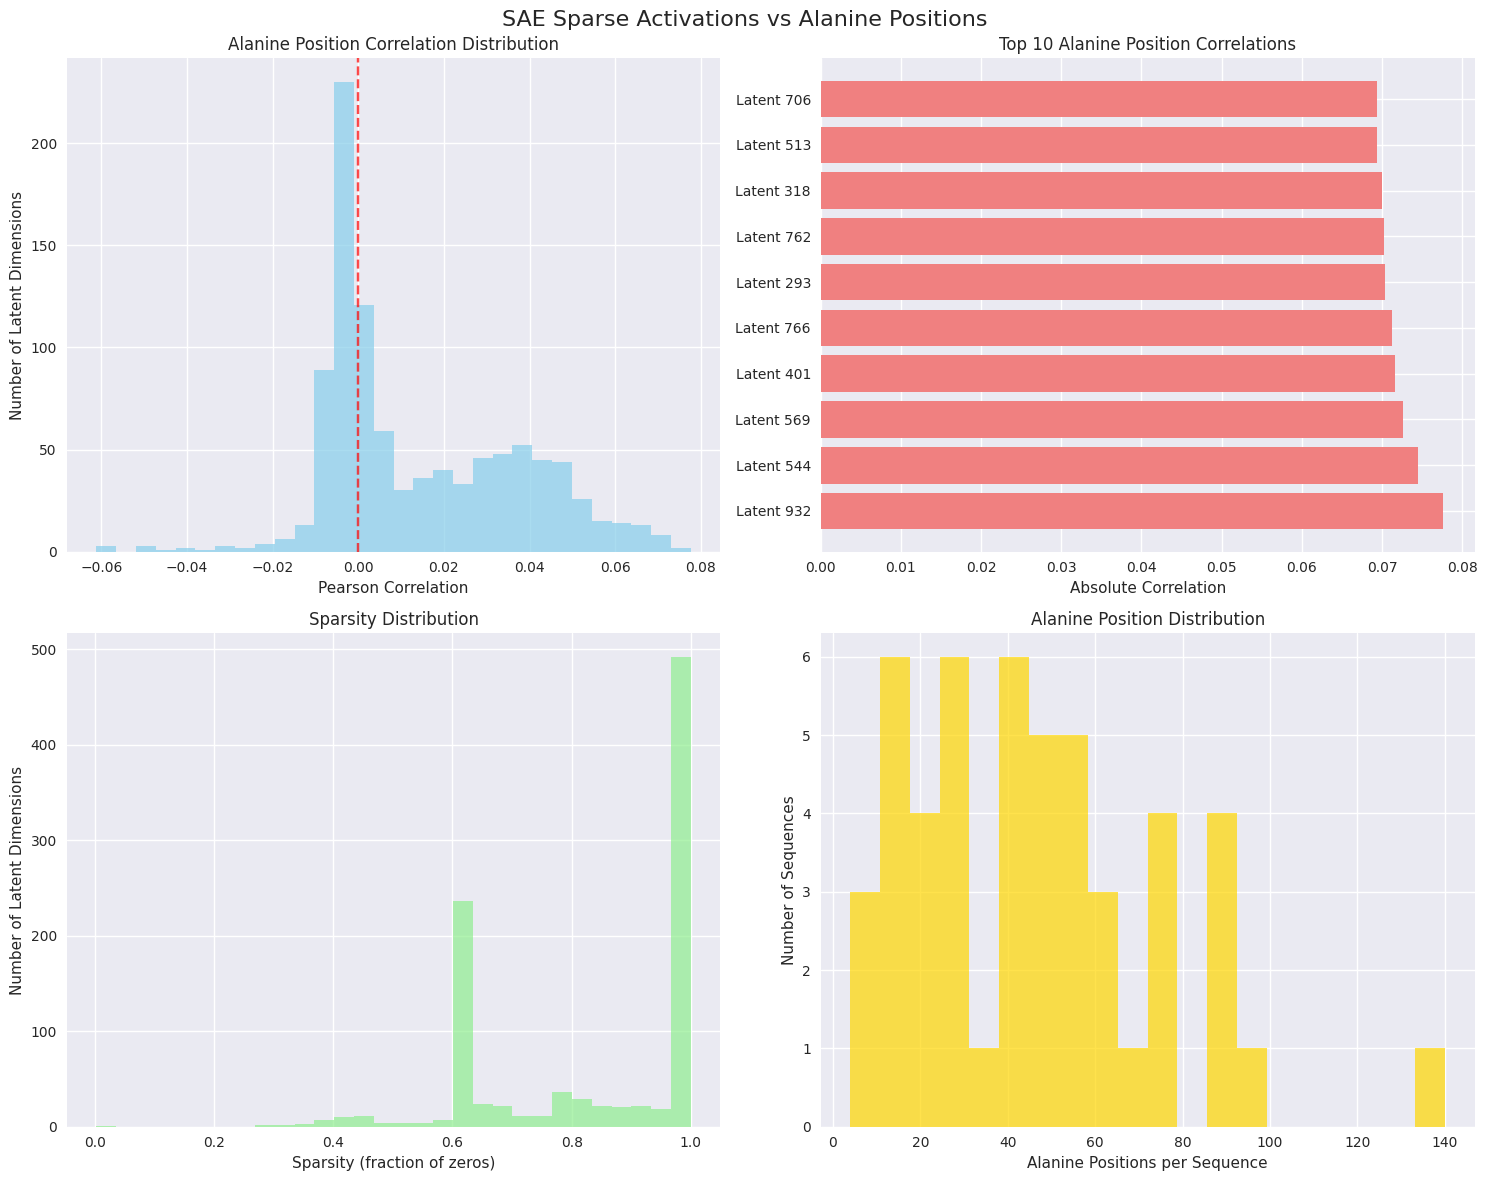

In [11]:
print("📊 Creating alanine position visualizations...")

plt.style.use('seaborn-v0_8')
fig, axes = plt.subplots(2, 2, figsize=(15, 12))
fig.suptitle('SAE Sparse Activations vs Alanine Positions', fontsize=16)

# 1. Alanine correlation distribution
ax1 = axes[0, 0]
n_latents = activations.shape[1]

correlations_list = []
for i in range(n_latents):
    key = (i, 'alanine')
    if key in correlations:
        correlations_list.append(correlations[key]['pearson'])
    else:
        correlations_list.append(0)

ax1.hist(correlations_list, bins=30, alpha=0.7, color='skyblue')
ax1.set_xlabel('Pearson Correlation')
ax1.set_ylabel('Number of Latent Dimensions')
ax1.set_title('Alanine Position Correlation Distribution')
ax1.axvline(x=0, color='red', linestyle='--', alpha=0.7)

# 2. Top alanine correlations
ax2 = axes[0, 1]
top_correlations = []
for key, corr_data in correlations.items():
    top_correlations.append({
        'latent': key[0],
        'correlation': abs(corr_data['pearson']),
        'p_value': corr_data['pearson_p']
    })

if top_correlations:
    top_correlations.sort(key=lambda x: x['correlation'], reverse=True)
    top_10 = top_correlations[:10]
    
    latents = [f"Latent {item['latent']}" for item in top_10]
    corrs = [item['correlation'] for item in top_10]
    
    ax2.barh(range(len(latents)), corrs, color='lightcoral')
    ax2.set_yticks(range(len(latents)))
    ax2.set_yticklabels(latents)
    ax2.set_xlabel('Absolute Correlation')
    ax2.set_title('Top 10 Alanine Position Correlations')

# 3. Sparsity analysis
ax3 = axes[1, 0]
# Calculate sparsity per latent dimension (mean across sequences)
if len(activations.shape) == 3:
    # 3D activations: (n_sequences, seq_len, n_latents)
    sparsity = (activations == 0).mean(axis=(0, 1))  # Mean across sequences and positions
else:
    # 2D activations: (n_sequences, n_latents)
    sparsity = (activations == 0).mean(axis=0)  # Mean across sequences

ax3.hist(sparsity, bins=30, alpha=0.7, color='lightgreen')
ax3.set_xlabel('Sparsity (fraction of zeros)')
ax3.set_ylabel('Number of Latent Dimensions')
ax3.set_title('Sparsity Distribution')

# 4. Alanine position distribution
ax4 = axes[1, 1]
alanine_counts = [mask.sum() for mask in alanine_masks]

ax4.hist(alanine_counts, bins=20, alpha=0.7, color='gold')
ax4.set_xlabel('Alanine Positions per Sequence')
ax4.set_ylabel('Number of Sequences')
ax4.set_title('Alanine Position Distribution')

plt.tight_layout()

plot_path = output_path / "alanine_position_correlation_analysis.png"
plt.savefig(plot_path, dpi=300, bbox_inches='tight')
print(f"   📈 Plot saved to: {plot_path}")

plt.show()

We see some interesting things here. In the top row, we see that almost all latent dimensions have almost zero correlation with our alanine mask. Even the most correlated latents are still only quite weakly correlated. Perhaps this is due in part to the fact that we are taking the embeddings from the output layer of the helical model here, rather than features from an earlier mayer, which might better reflect small-scale structure like short codon sequences. This deserves further investigation.

In the bottom left figure, we see that we are dealing with a large number of dead latent in out SAE model. A dead latent is a latent variable that is never activated because the network has simply learned to ignore it. Here that looks to be about half of our total latents, meaning our model is very inefficient. Techniques have been developed to reactivate these dead latents and it would be interesting to implement them.

## Step 7: Save Results

In [12]:
print("💾 Saving results...")

# Convert tuple keys to strings for JSON serialization
correlations_json = {}
for (latent_idx, feature_type), corr_data in correlations.items():
    key = f"{latent_idx}_{feature_type}"
    correlations_json[key] = corr_data

# Save correlations
correlations_path = output_path / "alanine_position_correlations.json"
with open(correlations_path, 'w') as f:
    json.dump(correlations_json, f, indent=2)

# Save statistical results
stats_path = output_path / "alanine_position_statistical_results.json"

# Convert tuple keys in statistical results as well (including nested dictionaries)
def convert_tuple_keys(obj):
    if isinstance(obj, dict):
        converted = {}
        for key, value in obj.items():
            if isinstance(key, tuple):
                new_key = f"{key[0]}_{key[1]}"
            else:
                new_key = key
            converted[new_key] = convert_tuple_keys(value)
        return converted
    elif isinstance(obj, list):
        return [convert_tuple_keys(item) for item in obj]
    else:
        return obj

stats_json = convert_tuple_keys(statistical_results)

with open(stats_path, 'w') as f:
    json.dump(stats_json, f, indent=2)

# Save summary CSV
summary_data = []
for (latent_idx, feature_type), corr_data in correlations.items():
    summary_data.append({
        'latent_dimension': latent_idx,
        'pearson_correlation': corr_data['pearson'],
        'pearson_p_value': corr_data['pearson_p']
    })

summary_df = pd.DataFrame(summary_data)
summary_path = output_path / "alanine_position_correlation_summary.csv"
summary_df.to_csv(summary_path, index=False)

print(f"   📄 Alanine position correlations saved to: {correlations_path}")
print(f"   📄 Statistical results saved to: {stats_path}")
print(f"   📄 Summary CSV saved to: {summary_path}")

💾 Saving results...
   📄 Alanine position correlations saved to: ../outputs/correlation_analysis/alanine_position_correlations.json
   📄 Statistical results saved to: ../outputs/correlation_analysis/alanine_position_statistical_results.json
   📄 Summary CSV saved to: ../outputs/correlation_analysis/alanine_position_correlation_summary.csv


## Step 8: Print Summary

In [13]:
print("\n" + "=" * 60)
print("📋 CORRELATION ANALYSIS SUMMARY")
print("=" * 60)

print(f"\n🔬 Experiment Details:")
print(f"   Model: {model_path}")
print(f"   Samples analyzed: {len(correlations)}")
print(f"   Latent dimensions: {pipeline.hidden_dim}")

print(f"\n📊 Alanine Position Correlation Results:")
print(f"   Total correlations calculated: {len(correlations)}")
print(f"   Significant correlations: {len(statistical_results.get('significant_features', {}))}")
print(f"   Total statistical tests: {statistical_results.get('total_tests', 0)}")

# Top correlations
if correlations:
    top_correlations = []
    for key, corr_data in correlations.items():
        top_correlations.append({
            'latent': key[0],
            'correlation': corr_data['pearson'],
            'p_value': corr_data['pearson_p']
        })
    
    top_correlations.sort(key=lambda x: abs(x['correlation']), reverse=True)
    
    print(f"\n🏆 Top 5 Alanine Position Correlations:")
    for i, corr in enumerate(top_correlations[:5]):
        print(f"   {i+1}. Latent {corr['latent']}: {corr['correlation']:.4f} (p={corr['p_value']:.4f})")

print(f"\n✅ Results saved to: {output_dir}")
print(f"\n🎉 Experiment completed successfully!")


📋 CORRELATION ANALYSIS SUMMARY

🔬 Experiment Details:
   Model: ../outputs/ablation_study_reconstruction/regular_sae_latent_1000
   Samples analyzed: 1000
   Latent dimensions: 1000

📊 Alanine Position Correlation Results:
   Total correlations calculated: 1000
   Significant correlations: 0
   Total statistical tests: 1000

🏆 Top 5 Alanine Position Correlations:
   1. Latent 932: 0.0777 (p=0.0546)
   2. Latent 544: 0.0745 (p=0.0568)
   3. Latent 569: 0.0726 (p=0.0582)
   4. Latent 401: 0.0716 (p=0.0589)
   5. Latent 766: 0.0712 (p=0.0593)

✅ Results saved to: ../outputs/correlation_analysis

🎉 Experiment completed successfully!


## Results Analysis

The experiment has completed! Here's what we found:

### Key Findings:
- **Low correlations**: None of the latent dimensions correlate strongly with alanine positions
- **Dead Latents**: Almost half of our latents appear to be dead

### Next Steps:
- Implement techniques to reduce proportion of dead latents
- Experiment with increasing the number of hidden latents to see if that creates higher-resolution features that correlate with individual amino acids like alanine
- Investigate whether using embeddings from earlier layers of the pre-trained Helix-mRNA model would correlate better with our features of interest